# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [2]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).

**Imports:**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

**Answer:**

In [4]:
def rng(M = 2):
    res = np.random.randn(1,M)
    return res

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

In [5]:
class Ball:
    def __init__(self, r : int):
        self.r = r
    
    def is_in_ball(self, point) -> bool:
        ''' 
        Takes a point as parameter and returns whether or not it is in the ball
        '''
        if np.linalg.norm(point) <= self.r:
            return True
        return False

In [6]:
def plot_result(W : list, x_inter):
    '''
    Plot the ball, the path and the intersection point if exists

    Params:
        W : path
        x_inter : point of intersection with the circle if appropriate, None otherwise
    '''

    # Create data for the circle
    theta = np.linspace(0, 2 * np.pi, 100)
    radius = 1

    # Calculate the x and y coordinates of the circle
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)

    plt.plot(x, y)

    X = [w[0] for w in W]
    Y = [w[1] for w in W]

    plt.plot(X, Y, 'o')

    if x_inter is not None:
        plt.plot((W[-2][0], W[-1][0]), (W[-2][1], W[-1][1]))           
        plt.plot(x_inter[0], x_inter[1],marker="o", color="black", zorder=10)
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Illustration of Brownian Motion')

    # Set the aspect ratio to be equal, so the circle looks like a circle
    plt.gca().set_aspect('equal')

    plt.show()

In [7]:
def brownian_motion(niter : int, x : tuple, step : float, rng):
    ''' 
    Params:
        niter: number max of iterations
        x: starting point
        step: step size
        rng: random generator
    Returns:
        (W, point of intersection) if appropriate
        (W, None) otherwise
    '''

    B = Ball(1) 
    
    def get_intersection(x1, x2) -> tuple:  
        '''
        Takes two points and look for the intersection of the ball and the line that cross both
        
        param:
            x1: (x1_1, ... , x1_M) coordonates of the first point
            x2: (x2_1, ... , x2_M) coordonates of the second point
        
        returns:
            x: (x_1, ... , x_M) the intersection of the line and the ball
        '''

        sum = 0
        for i in range(len(x1)):
            sum += x2[i]*(x1[i]-x2[i])

        roots = np.roots([np.linalg.norm(x1-x2)**2, 2*sum, np.linalg.norm(x2)**2-1])
        
        for t in roots:
            if 0 <= t <= 1:
                return (x1-x2)*t + x2
        
        # Should not run that line
        return None
    
    
    # Initialize the path to x
    W = [x]

    if not B.is_in_ball(x):
        print("The initial point is not in the ball")

    while niter:
        # Generation of a random number 
        diffusion = rng()[0]

        # Generation of the next point         
        next_x = W[-1] + np.sqrt(step)*diffusion

        # Append the new point to the path
        W.append(next_x)            

        # If the next point is out of the ball
        if not B.is_in_ball(next_x):          
            x_inter = get_intersection(W[-2], W[-1])          
            return (W, x_inter)  

        niter -= 1  

    # In order to return always the same datatype
    # The functions returns None if none of the point went out of the circle
    return (W, None)        


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

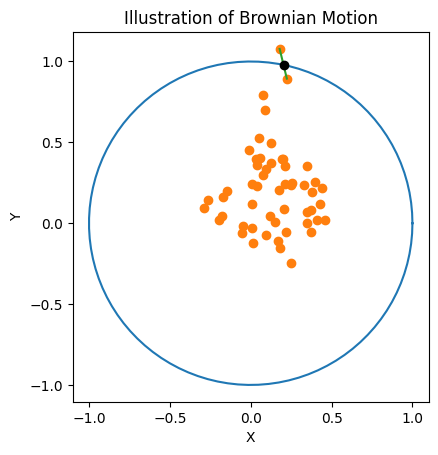

In [8]:
(W, x_inter) = brownian_motion(1000, (0.2,0.4), 10**(-2), rng)
plot_result(W, x_inter)

4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

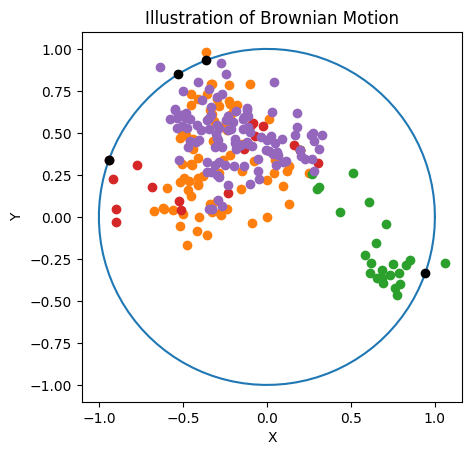

In [9]:
(W1, x_inter1) = brownian_motion(1000, (0.2,0.4), 10**(-2), rng)
(W2, x_inter2) = brownian_motion(1000, (0.2,0.4), 10**(-2), rng)
(W3, x_inter3) = brownian_motion(1000, (0.2,0.4), 10**(-2), rng)
(W4, x_inter4) = brownian_motion(1000, (0.2,0.4), 10**(-2), rng)

# Create data for the circle
theta = np.linspace(0, 2 * np.pi, 100)
radius = 1

# Calculate the x and y coordinates of the circle
x = radius * np.cos(theta)
y = radius * np.sin(theta)

plt.plot(x, y)

X1 = [w[0] for w in W1]
Y1 = [w[1] for w in W1]

X2 = [w[0] for w in W2]
Y2 = [w[1] for w in W2]

X3 = [w[0] for w in W3]
Y3 = [w[1] for w in W3]

X4 = [w[0] for w in W4]
Y4 = [w[1] for w in W4]

plt.plot(X1, Y1, 'o')
plt.plot(X2, Y2, 'o')
plt.plot(X3, Y3, 'o')
plt.plot(X4, Y4, 'o')

for x_inter in [x_inter1, x_inter2, x_inter3, x_inter4]:
    if x_inter is not None:
        plt.plot(x_inter[0], x_inter[1],marker="o", color="black", zorder=10)

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Illustration of Brownian Motion')

# Set the aspect ratio to be equal, so the circle looks like a circle
plt.gca().set_aspect('equal')

plt.show()

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

In [10]:
# Use the algorithm for a 5-dimension space
dimension = 5
brownian_motion(1000, (0.2, 0.4, 0.2, 0.3, 0), 10**(-2), lambda : rng(dimension))

([(0.2, 0.4, 0.2, 0.3, 0),
  array([0.10519529, 0.48100066, 0.16027879, 0.20024689, 0.2507904 ]),
  array([0.13076811, 0.37974686, 0.1921071 , 0.3259905 , 0.27258245]),
  array([0.15675103, 0.32091607, 0.19584654, 0.35435657, 0.31228033]),
  array([0.04254961, 0.31267611, 0.29737397, 0.29114639, 0.37409087]),
  array([-0.02956043,  0.27794677,  0.13667346,  0.28680254,  0.53144807]),
  array([-0.03452127,  0.26028014,  0.2112658 ,  0.2849176 ,  0.35950572]),
  array([-0.10294205,  0.2123064 ,  0.13953067,  0.14228521,  0.32594098]),
  array([-0.06351271,  0.19933371, -0.04936449,  0.05255351,  0.40028333]),
  array([-0.2039738 ,  0.10921774, -0.18663395, -0.04179748,  0.32542948]),
  array([-0.22120081,  0.05158549, -0.20154397, -0.25988071,  0.34197394]),
  array([-0.44829666,  0.22581389, -0.23875296, -0.18377901,  0.42273533]),
  array([-0.59554907,  0.27622143, -0.03575378, -0.26648981,  0.34079872]),
  array([-0.57509755,  0.37056914, -0.08256147, -0.08776963,  0.27949768]),
  arr

---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

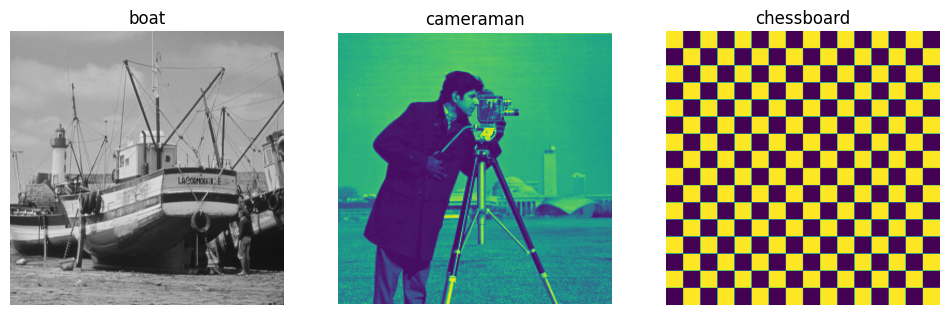

In [11]:
from PIL import Image

names = ["boat", "cameraman", "chessboard"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
images = []

for i, name in enumerate(names):
    image_path = 'img/{}.png'.format(name)
    image = Image.open(image_path)
    images.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')  
    axes[i].set_title(name)  
plt.show()

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

In [27]:
def plot_img_log(image : Image):
    '''
    Takes a PIL image as an argument, plot it and displays |F(X)|² in logarithmic scale
    '''

    # Initialization of the plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))   

    # Image -> np.array
    X = np.array(image)

    # 2D discrete Fourier transform
    X_fourier = np.fft.fft2(X)     

    # Spectrum of the image
    spectrum = np.abs(X_fourier)

    # Shifted spectrum of the image
    shifted_spectrum = np.fft.fftshift(spectrum)

    # Plot result
    log_spectrum = np.log10(spectrum + 1)                   # Add 1 to avoid log(0)
    log_shifted_spectrum = np.log10(shifted_spectrum + 1)   # Same
    axes[0].imshow(image)
    axes[1].imshow(log_spectrum, cmap='gray') 
    axes[2].imshow(log_shifted_spectrum, cmap='gray')   
    plt.title('Spectrum in Logarithmic scale of the image') 
    plt.show()

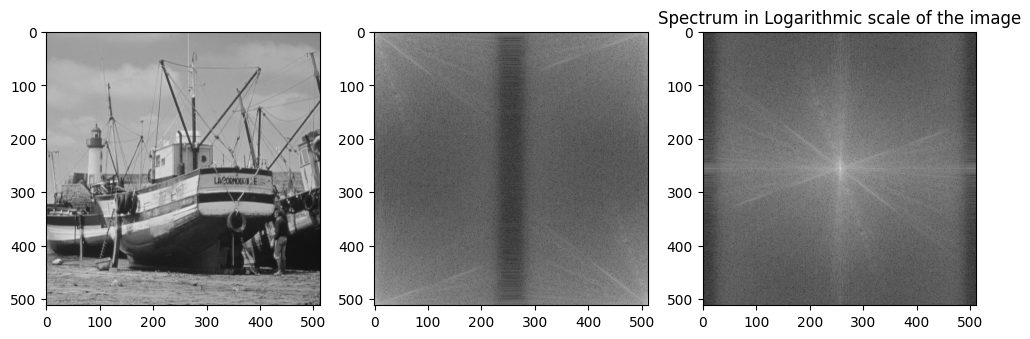

In [26]:
plot_img_log(images[0])

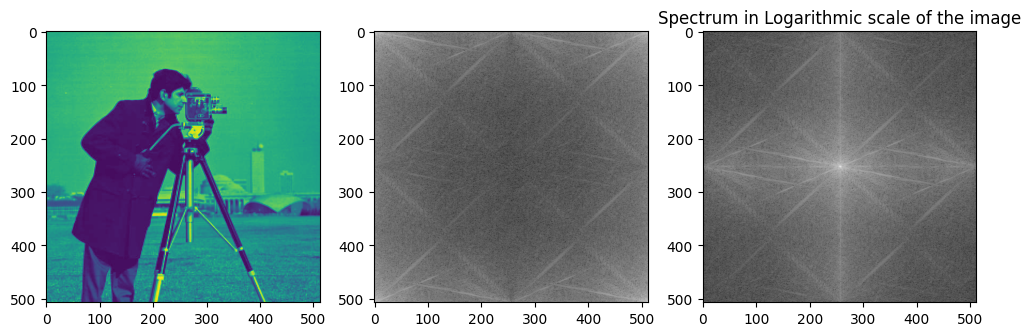

In [25]:
plot_img_log(images[1])

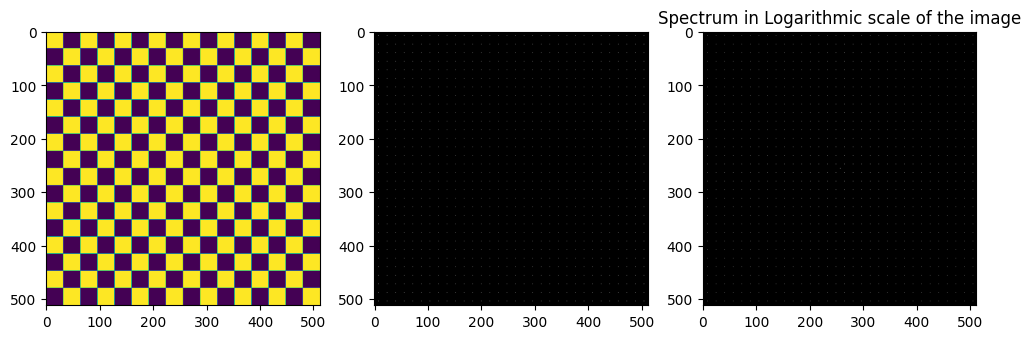

In [24]:
plot_img_log(images[2])

After having shifted the image the point associated to the null frequency is at the center of the image

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

In [13]:
def ideal_lowpass_filter(image : Image, cutoff_frequency: tuple):
    '''
    Apply a lowpass filter on the given image
    
    Params:
        image: the image to apply the filter on
        cutoff_frequency: the cutoff frequency of the filter

    Returns the filtered image
    '''

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Get the dimensions of the image
    height, width = image_array.shape[:2]

    # Calculate the cutoff frequencies
    fc_x, fc_y = cutoff_frequency

    # Apply 2D Fourier transform to the image
    image_fft = np.fft.fft2(image_array)

    # Create frequency grids
    u = np.fft.fftfreq(height)
    v = np.fft.fftfreq(width)
    U, V = np.meshgrid(u, v)

    # Create a mask for filtering
    mask = np.logical_and(np.abs(U) <= fc_x, np.abs(V) <= fc_y)

    # Apply the mask in the frequency domain
    filtered_image_fft = image_fft * mask.T

    # Get the filtered image by returning to the spatial domain
    filtered_image = np.fft.ifft2(filtered_image_fft).real

    return filtered_image

In [14]:
def plot_filtered_images(image_names : list, cutoff_frequency : tuple):
    '''
    Takes images and applies a low-pass filter using the ideal_lowpass_filter function

    Params:
        image_names: a list of the images name. They have to be stored in a directory called img
        cutoff_frequency: the cutoff frequency of the filter
    '''

    fig, axes = plt.subplots(1, len(image_names), figsize=(12, 4))
        
    for i, name in enumerate(image_names):
        
        # Open the image
        image_path = f'img/{name}.png'
        image = Image.open(image_path)
        
        # Filter it
        filtered_image = ideal_lowpass_filter(image, cutoff_frequency)
        
        # Show it
        axes[i].imshow(filtered_image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(name)
    
    plt.show()

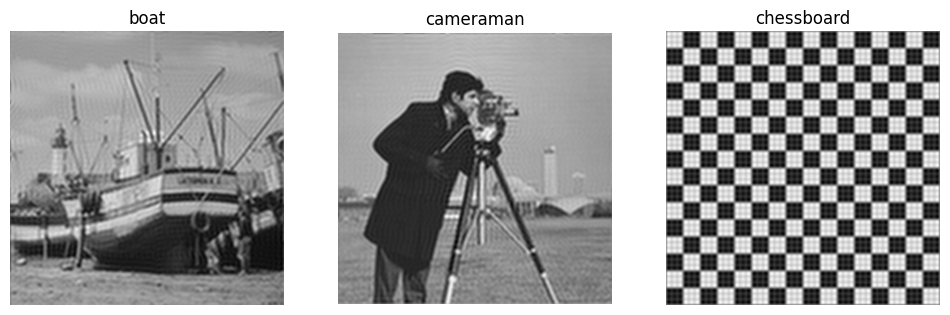

In [15]:
image_names = ["boat", "cameraman", "chessboard"]
cutoff_frequency = (0.1, 0.1)

plot_filtered_images(image_names, cutoff_frequency)

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

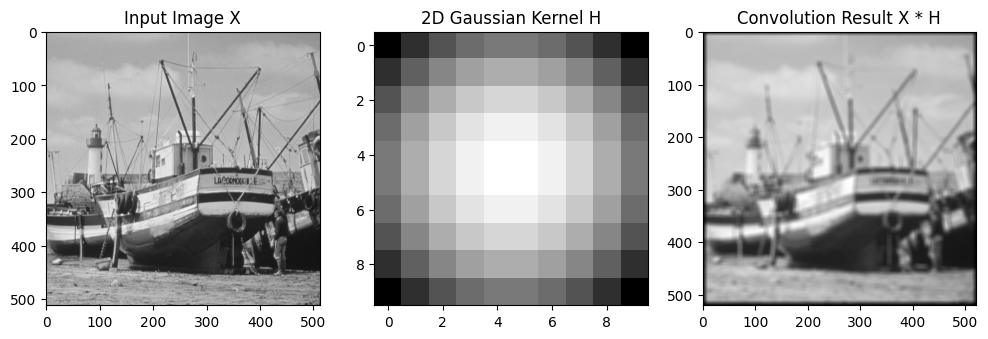

In [16]:
from scipy.signal.windows import gaussian

# Parameters
M2 = N2 = 10
sigma_y = sigma_x = 10

# Generate 1D Gaussian windows
w_y = gaussian(M2, std=sigma_y)
w_x = gaussian(N2, std=sigma_x)

# Create the 2D Gaussian kernel H by taking the outer product
H = np.outer(w_y, w_x)

image_path = f'img/boat.png'
image = Image.open(image_path)
X = np.array(image)

# Compute M and N
M1, N1 = X.shape
M = M1 + M2 - 1
N = N1 + N2 - 1

# Perform linear convolution using the discrete convolution theorem and 0-padding
X_fft = np.fft.rfft2(X, s=(M, N))
H_fft = np.fft.rfft2(H, s=(M, N))
result_fft = X_fft * H_fft
result = np.fft.irfft2(result_fft, s=(M, N))

# Display the result
plt.figure(figsize=(12, 12))
plt.subplot(131), plt.imshow(X, cmap='gray'), plt.title('Input Image X')
plt.subplot(132), plt.imshow(H, cmap='gray'), plt.title('2D Gaussian Kernel H')
plt.subplot(133), plt.imshow(result, cmap='gray'), plt.title('Convolution Result X * H')
plt.show()
